# Inferencing Coarse Tuning Model

In [5]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer

from PIL import Image
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import matplotlib.cm as cm
from matplotlib.pyplot import subplots

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib

import yaml

zsh:1: command not found: nvcc
torch:  2.0 ; cuda:  2.0.1
detectron2: 0.6


In [6]:
#!scp apaurevi@cedar.computecanada.ca:projects/def-baugh/apaurevi/QuantumDotControl/output/model_0004999.pth ./output/model_bias_traingles.pth

In [14]:
# Load trained model path
model_path = os.path.join("../models/bias_triangles", "model_bias_triangles_5000.pth")  # path to the model we just trained
config_path = "src/config.yaml"

model_name = 'psb'
processor = 'cpu'


In [33]:
with open(config_path, 'r') as config_yaml:
            model_yaml = yaml.load(config_yaml, Loader=yaml.FullLoader)
            model_config = model_yaml[model_name]
            model_info = model_config['info']
            model_hyperparams = model_config['hyperparameters']

            model_device = model_yaml['device']

ROOT_DIR = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/bias_triangles"

MODEL_DATA_DIR = os.path.join(ROOT_DIR, "processed")

MODEL_TRAIN_DATA_DIR = os.path.join(MODEL_DATA_DIR,"train")
MODEL_VAL_DATA_DIR = os.path.join(MODEL_DATA_DIR,"val")
MODEL_TEST_DATA_DIR = os.path.join(MODEL_DATA_DIR,"test")

In [34]:
from detectron2.engine import DefaultTrainer

print(model_hyperparams)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bias_triangle_train",)
cfg.DATASETS.TEST = ()

cfg.MODEL.DEVICE = processor 
cfg.DATALOADER.NUM_WORKERS = model_device[processor]['num_workers']

cfg.SOLVER.IMS_PER_BATCH = model_hyperparams['batch_num']
cfg.SOLVER.BASE_LR = model_hyperparams['learning_rate']
cfg.SOLVER.MAX_ITER = model_hyperparams['num_epochs']
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = model_hyperparams['batch_size_per_img']
cfg.MODEL.ROI_HEADS.NUM_CLASSES = model_info['num_of_classes'] 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75  # set a custom testing threshold
predictor = DefaultPredictor(cfg)


{'learning_rate': 0.0002, 'augments_per_sim_img': 2, 'augments_per_exp_img': 50, 'num_epochs': 5000, 'batch_num': 1, 'batch_size_per_img': 128}
[04/18 15:17:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../models/bias_triangles/model_bias_triangles_5000.pth ...


In [35]:
def get_bias_triangles_dict(img_dir):
    json_file = os.path.join(img_dir, "via_bias_triangle_11Apr2024_12h19m_json.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        record["file_name"] = os.path.join(img_dir, v["filename"])
        record["image_id"] = idx

        annos = v["regions"]

        objs = []

        if type(annos) == list: # custom JSONs are in list format need to make them the same
             annos = dict(enumerate(annos))

        for _, anno in annos.items():

            regions = anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]

            # if len(px) <= 10 or len(py) <= 10:
            #         # print("Ignoring polygon from ", v["filename"], "because a polygon was too small for detectron2.")
            #         continue
            
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            category_dict = {"unblocked":0, "blocked":1}
            category_id = category_dict[regions["label"]]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_id,
            }

            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

## Validation

In [36]:
DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["train", "val"]:
    DatasetCatalog.register("bias_triangles" + d, lambda d=d: get_bias_triangles_dict(os.path.join(MODEL_DATA_DIR,d)))
    MetadataCatalog.get("bias_triangles" + d).set(thing_classes=list(model_info['class_dict'].keys()))

csd_train_metadata = MetadataCatalog.get("bias_triangles_train")
csd_val_metadata = MetadataCatalog.get("bias_triangles_val")

def check_image_exists(directory, image_name):
    # Get the list of files in the directory
    files = os.listdir(directory)

    # Check if the image_name exists with any image extension
    for file in files:
        if file == image_name:
            print(file, image_name)
            return True

    return False

dataset_dicts = get_bias_triangles_dict(MODEL_VAL_DATA_DIR)
for d in random.sample(dataset_dicts, 1):    

    im = cv2.imread(d['file_name'])

    

    print(d['file_name'])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    v = Visualizer(im[:, :, ::-1],
                   metadata=csd_val_metadata, 
                   scale=3,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()
    
    plt.cla()
    plt.clf()
    plt.close()
    visualizer = Visualizer(im[:, :, ::-1], metadata=csd_val_metadata, scale=3)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1],cmap=cm.summer)
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/data/bias_triangles/processed/val/via_bias_triangle_11Apr2024_12h19m_json.json'

## Experimental Test

/Users/andrijapaurevic/miniforge3/envs/detectron2/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[1] None
tensor(1) tensor(0.9493)


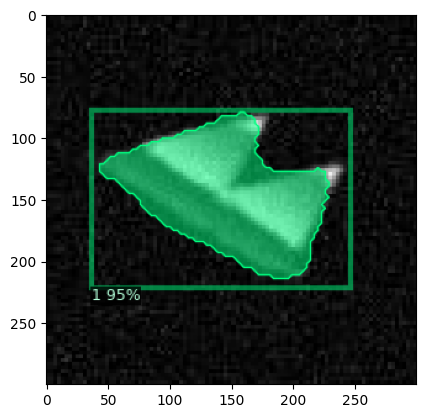

In [37]:
test_image = os.path.join(MODEL_TEST_DATA_DIR, "test_44_1_sim_blocked.jpg")
im = cv2.imread(test_image)
im = cv2.rotate(im, cv2.ROTATE_180)
im_blur = cv2.bilateralFilter(im, 3,50,50)
gray = cv2.cvtColor(im_blur, cv2.COLOR_BGR2GRAY)
# Define the sharpening kernel (Laplacian)
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

# # Apply the kernel to the image using filter2D
# sharpened_image = cv2.filter2D(gray, -1, kernel)

# plt.imshow(sharpened_image)
# plt.colorbar()
# plt.show()

# # sobelxy = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=3) # Combined X and Y Sobel Edge Detection
# # plt.imshow(cv2.rotate(sobelxy.astype('uint8'), cv2.ROTATE_180))
# # plt.colorbar()
# # plt.show()


# # im_adap_thres = cv2.adaptiveThreshold(sobelxy.astype('uint8'),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
# #  cv2.THRESH_BINARY_INV,21,25)

# # # plt.imshow(im_thres)
# # # plt.colorbar()
# # # plt.show()
# # # im = cv2.cvtColor(im_thres, cv2.COLOR_GRAY2RGB)
# # # plt.imshow(im)
# # # plt.colorbar()
# # # plt.show()
# # im = cv2.rotate(im_adap_thres, cv2.ROTATE_180)
# # plt.imshow(im)
# # plt.colorbar()
# # plt.show()
# # im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)

# # im = cv2.rotate(sobelxy.astype('uint8'), cv2.ROTATE_180)
# im = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
# im = cv2.rotate(im, cv2.ROTATE_180)
# plt.imshow(im)
# plt.colorbar()
# plt.show()
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
bias_triangle_test_metadata = MetadataCatalog.get("bias_triangles_val")
v = Visualizer(im[:, :, ::-1],
                metadata=bias_triangle_test_metadata, 
                scale=3,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
)

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
instances = outputs["instances"].to("cpu")
for i in range(len(instances)):
    mask = instances.pred_masks[i]

    confidence_score = instances.scores[i]
    class_label = instances.pred_classes[i]
    print(class_label, confidence_score)
    
plt.imshow(out.get_image())

plt.show()